In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn
sn.set(rc={'figure.figsize':(11.7,11.7)})


import torch
from torchvision import datasets, transforms

In [12]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor, 
                                 lambda x: x.view(784)])

MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

In [13]:
dataloader = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=len(MNIST_train))
images, labels = next(iter(dataloader))

In [20]:
sample_data = images.numpy()

In [21]:
from sklearn import decomposition
pca = decomposition.PCA()

In [25]:
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(sample_data)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

shape of pca_reduced.shape =  (60000, 2)


In [26]:
pca_data = np.vstack((pca_data.T, labels)).T

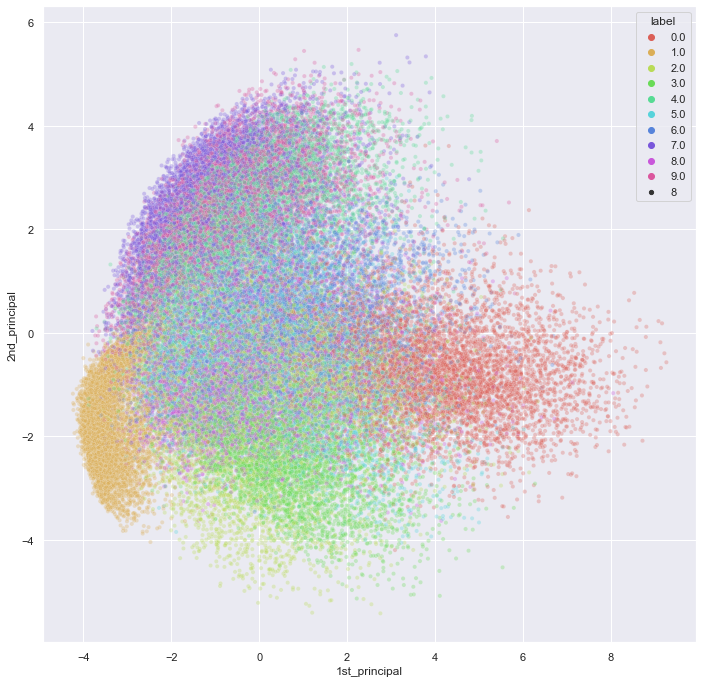

In [45]:

# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.scatterplot(
    x="1st_principal", y="2nd_principal",
    hue="label",
    palette=sn.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    s=1,
    alpha=0.3
)
plt.show()

# t-SNE

In [49]:
from sklearn.manifold import TSNE


In [68]:
# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = sample_data[0:10000,:]
labels_1000 = labels[0:10000]


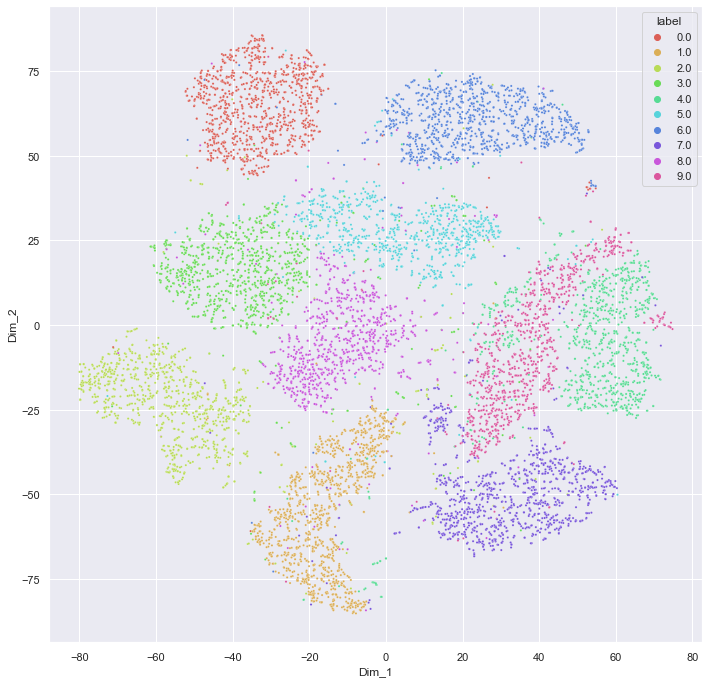

In [69]:
model = TSNE(n_components=2, random_state=0, learning_rate=100.0, init="random")


tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.scatterplot(
    x="Dim_1", y="Dim_2",
    hue="label",
    palette=sn.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    s=5,
)

plt.show()

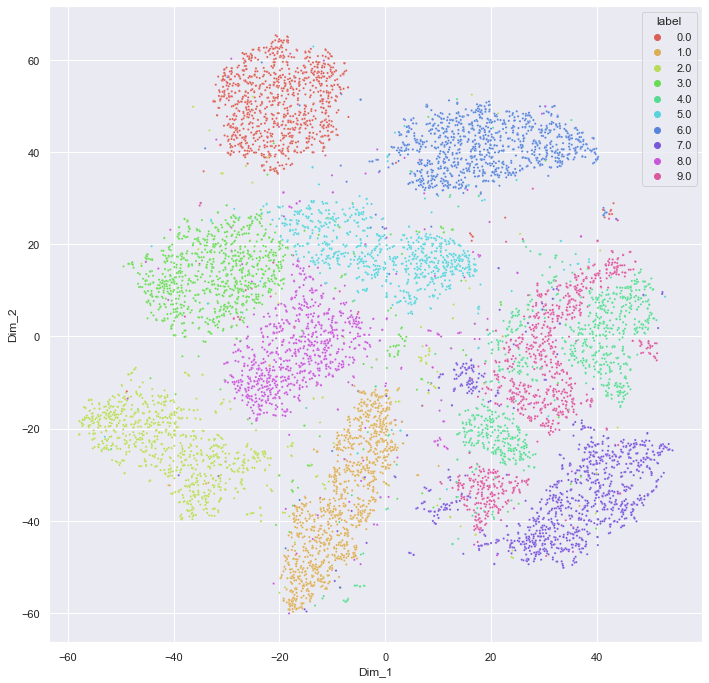

In [70]:
model = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=100.0, init="random")


tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.scatterplot(
    x="Dim_1", y="Dim_2",
    hue="label",
    palette=sn.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    s=5,
)

plt.show()

### Автокодировщик

In [91]:
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [76]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor])

In [77]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

In [78]:
class EncoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d
# 28x28x1
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1, 6, kernel_size = 5))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(6))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2)) # 12x12x6
        
        self.layers.add_module('conv2', torch.nn.Conv2d(6, 16, kernel_size = 5)) # 8x8x16
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(16))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2)) # 4x4x16
        
        self.layers.add_module('conv3', torch.nn.Conv2d(16, self.d, kernel_size = 3)) # 2x2xd
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('pool3', torch.nn.MaxPool2d(kernel_size = 2)) # 1x1xd

        self.layers.add_module('flatten', torch.nn.Flatten())

    def forward(self, input):
        return self.layers(input)

In [79]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(object_dim, d)
        
    def forward(self, x):
        return self.linear(x)

In [80]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, object_dim):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(d, object_dim)
        
    def forward(self, x):
        return self.linear(x)

In [81]:
class Autoencoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.encoder = Encoder(np.prod(digit_size), d)
        self.decoder = Decoder(d, np.prod(digit_size))
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

In [82]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

In [83]:
class DecoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d

        self.layers = torch.nn.Sequential()
        self.layers.add_module('reshape1', Reshape(self.d, 1, 1))
        
        self.layers.add_module('conv1', torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(128))
        self.layers.add_module('relu1', torch.nn.ReLU())
        
        self.layers.add_module('conv2', torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False))
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(64))
        self.layers.add_module('relu2', torch.nn.ReLU())
        
        self.layers.add_module('conv3', torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False))
        self.layers.add_module('bnorm3', torch.nn.BatchNorm2d(32))
        self.layers.add_module('relu3', torch.nn.ReLU())

        self.layers.add_module('conv4', torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False))
        # 28x28x1
        self.layers.add_module('sigmoid', torch.nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

In [84]:
class AutoencoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d
        
        self.encoder = EncoderCNN(d)
        self.decoder = DecoderCNN(d)
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

#### Определение модели

In [99]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam

In [100]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device))
    
    loss = loss_function(output, x_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [101]:
def train_epoch(train_generator, model, loss_function, optimizer):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [102]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [ ]:
autoencoder = AutoencoderCNN(2)
autoencoder.to(device)

trainer(count_of_epoch=5, 
        batch_size=64, 
        dataset=MNIST_train,
        model=autoencoder, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr = 0.001)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [126]:
dataloader = torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=10000)
images, labels = next(iter(dataloader))

In [127]:
t = autoencoder.encode(images)

In [128]:
t

tensor([[2.9441, 0.0000],
        [5.7096, 0.0000],
        [2.5157, 0.0000],
        ...,
        [2.6285, 0.0000],
        [2.2884, 0.0000],
        [2.2043, 0.0000]], grad_fn=<ReshapeAliasBackward0>)

In [129]:
cae_data = t.detach().numpy()

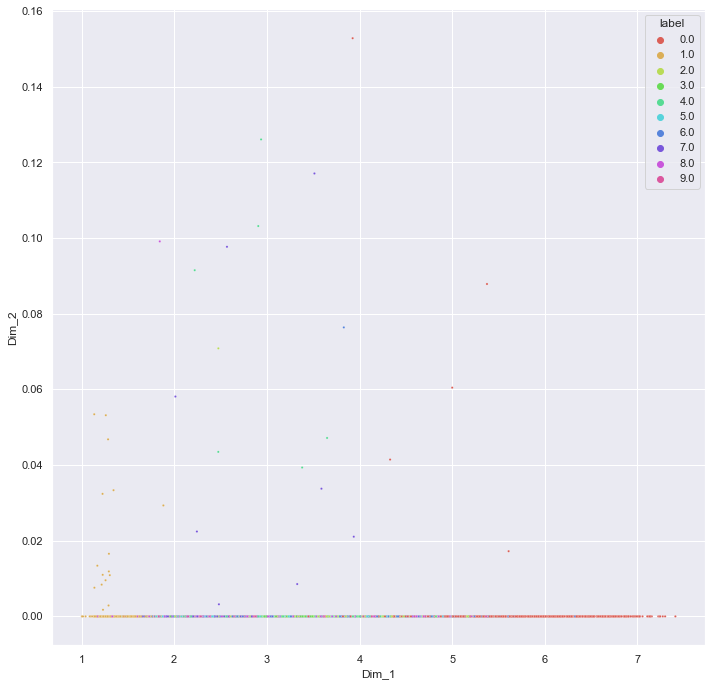

In [130]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((cae_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.scatterplot(
    x="Dim_1", y="Dim_2",
    hue="label",
    palette=sn.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    s=5,
)

plt.show()